<a href="https://colab.research.google.com/github/mitali72/CS753-Hacker/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Right to Talk: An Audio-Visual Transformer Approach

> The main idea of the paper was to identify the main speaker in both the audio and visual channels in a turn-taking conversation. The paper proposed an audio-visual transformer-based approach, with the following steps to generate a mask for the audio and video channel to highlight the main speaker:
1. Visual and audio self-attention
2. Audio-visual correlation
3. Main speaker localization 


In [ ]:
!conda install -c conda-forge ffmpeg
!pip install -U yt-dlp
!pip install ffmpeg-python
!pip install --trusted-host pypi.python.org moviepy

/bin/bash: conda: command not found
     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 2.0 MB 34.4 MB/s 
     |████████████████████████████████| 112 kB 29.6 MB/s 
     |████████████████████████████████| 218 kB 68.5 MB/s 
     |████████████████████████████████| 357 kB 64.4 MB/s 


## Download Audio and Video files from youtube
## AVSpeech dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# rm -r /content/train
!python /content/drive/MyDrive/Hacker/downloader.py train

## Add Interruptions

In [ ]:
!pip install pydub

In [ ]:
import random
from pydub import AudioSegment
def overlap_files(audio_file1, audio_file2,out_path):
  sound1 = AudioSegment.from_wav(audio_file1)
  sound2 = AudioSegment.from_wav(audio_file2)
  interruption_len=min(int(len(sound1)/3),len(sound2))
  i=random.randint(0,len(sound1)-interruption_len)
  mixed = sound1[:i]+sound1[i:i+interruption_len].overlay(sound2[:interruption_len])+sound1[i+interruption_len:]
  mixed.export(out_path+'_2N.wav', format="wav")

In [ ]:
import os
all_files = os.listdir('/content/train/audio')
os.makedirs('/content/train/audio_2N/',exist_ok=True)
for i in range(len(all_files)):
  j=random.choice(list(range(0,i)) + list(range(i+1, len(all_files))))
  in_dir='/content/train/audio/'
  out_dir='/content/train/audio_2N/'
  overlap_files(in_dir+all_files[i], in_dir+all_files[j],out_dir+all_files[i][:-10])

## Sample audio file with interruption

In [ ]:
import IPython
IPython.display.Audio('/content/train/audio/G7xm-5aDZyg_audio.wav')

## Segment audio files

In [ ]:
from pydub import AudioSegment 
from pydub.utils import make_chunks
import os


def segment_audio(file_name,out_dir):
    myaudio = AudioSegment.from_file(file_name, "wav") 
    chunk_length_ms = 2000 
    chunks = make_chunks(myaudio,chunk_length_ms)
    del chunks[-1]
    for i, chunk in enumerate(chunks): 
        chunk_name = os.path.join(out_dir,str(i)+".wav")
        # chunk_name = out_dir + "/{0}.wav".format(i) 
        chunk.export(chunk_name, format="wav")

In [ ]:
# all_audio_files = os.listdir('/content/train/audio_2N')
# os.makedirs('/content/train/segmented_audiofiles/',exist_ok=True)
# for audio_file in all_audio_files:
#     file=os.path.join('/content/train/audio_2N',audio_file)
#     segment_audio(file,audio_file[:-4])

## Interrupted audio segments

In [ ]:
all_audio_files = os.listdir('/content/train/audio_2N')
os.makedirs('/content/train/segmented_audiofiles/',exist_ok=True)
for audio_file in all_audio_files:
    out_dir = '/content/train/segmented_audiofiles/'+audio_file[:-7]
    os.makedirs(out_dir,exist_ok=True)
    file=os.path.join('/content/train/audio_2N',audio_file)
    segment_audio(file,out_dir)

## Target audio segments

In [ ]:
all_audio_files = os.listdir('/content/train/audio')
os.makedirs('/content/train/target_audio/',exist_ok=True)
for audio_file in all_audio_files:
    out_dir = '/content/train/target_audio/'+audio_file[:-10]
    os.makedirs(out_dir,exist_ok=True)
    file=os.path.join('/content/train/audio',audio_file)
    segment_audio(file,out_dir)

## STFT

In [ ]:
import librosa
import numpy as np
def generate_spectrogram_magphase(audio_file, hop=128, n_fft=512):
    audio, sample_rate = librosa.load(audio_file,sr=16000)
    spectro = librosa.core.stft(audio, hop_length=hop, n_fft=n_fft, center=True)
    # spectro = np.expand_dims(spectro,axis = 2)
    spectro_mag, spectro_phase = librosa.core.magphase(spectro)
    spectro_mag = np.expand_dims(spectro_mag, axis=2)
    spectro_phase = np.expand_dims(np.angle(spectro_phase), axis=2)
    return spectro,spectro_mag, spectro_phase

In [ ]:
audio_file='/content/train/segmented_audiofiles/DxpQmBfA6vM/3.wav'
spectro, spectro_mag, spectro_phase=(generate_spectrogram_magphase(audio_file))

In [ ]:
print(spectro.shape, spectro_mag.shape,spectro_phase.shape)
print(np.min(spectro_mag))

(257, 251) (257, 251, 1) (257, 251, 1)
4.0024325e-08


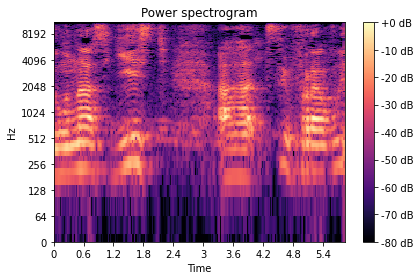

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(abs(spectro),ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Audio Embedding

In [ ]:
import torch
import torch.nn as tnn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = tnn.Sequential(
        tnn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        tnn.BatchNorm2d(chann_out),
        tnn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ tnn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return tnn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = tnn.Sequential(
        tnn.Linear(size_in, size_out),
        tnn.BatchNorm1d(size_out),
        tnn.ReLU()
    )
    return layer

class VGG16(tnn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        # Conv blocks (BatchNorm + ReLU activation added in each block)
        # self.bn1 = tnn.BatchNorm2d(1)
        self.layer1 = vgg_conv_block([1,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        # FC layers
        # self.layer6 = vgg_fc_layer(7*7*512, 4096)
        # self.layer7 = vgg_fc_layer(4096, 4096)
        self.layer6 = tnn.Linear(28672,512)

        # # Final layer
        # self.layer8 = tnn.Linear(4096, n_classes)
        self.fc_qka = tnn.Linear(512,512)
        self.fc_kka = tnn.Linear(512,512)
        self.fc_vka = tnn.Linear(512,512)

    def forward(self, x):
        # out = self.bn1(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        vgg16_features = self.layer5(out)
        out = vgg16_features.view(out.size(0), -1)
        out_feat = self.layer6(out)

        qka = self.fc_qka(out_feat)
        kka = self.fc_kka(out_feat)
        vka = self.fc_vka(out_feat)
        # out = self.layer6(out_feat)
        # out = self.layer7(out)
        # out = self.layer8(out)

        return out_feat, qka, kka, vka
        # return out

class EtaDecoder(tnn.Module):
    def __init__(self):
          super(EtaDecoder, self).__init__()

          self.fc1 = tnn.Linear(512,1024)
          self.fc2 = tnn.Linear(1024,512)
          self.bn1 = tnn.BatchNorm1d(512)

          #decoder
          self.fcd1 = tnn.Linear(512,1024)
          self.fcd2 = tnn.Linear(1024,257*251)
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.bn1(x)
        za = out + x
        mask = self.fcd1(za)
        mask = self.fcd2(mask)

        return mask

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor()
    ])

In [ ]:
# # test_input = transform(np.expand_dims(spectro_mag,axis = (2)))
# test_input = transform(spectro_mag)
# print(test_input.shape)
# vgg16 = VGG16()
# # audio_emb, qka, kka, vka = vgg16(torch.unsqueeze(test_input,0))
# audio_emb = vgg16(torch.unsqueeze(test_input,0))
# print(audio_emb.shape)

In [ ]:
import math

def generate_attention(audio_emb, qa, ka, va):
  alpha = tnn.Softmax(dim = 1)(qa@ka.t()/math.sqrt(512))
  za_input = audio_emb + alpha@va
  return za_input

#Audio Loss
def audio_loss(mask,x_spec, y_spec):
  mask = torch.reshape(mask,(-1,1,257,251))
  loss = (mask*x_spec-y_spec).abs().sum(dim = (1,2,3)).mean()
  return loss

In [ ]:
EPOCH = 10
vgg16 = VGG16()
eta_decoder = EtaDecoder()
optimizer = torch.optim.Adam(list(vgg16.parameters()) + list(eta_decoder.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn=tnn.L1Loss()

In [ ]:
def evaluate(vgg16,eta_decoder,seg_audio_folders):
  vgg16.eval()
  eta_decoder.eval()
  avg_loss = 0
  cnt = 0
  for it, seg_audio_folder in enumerate(seg_audio_folders):
    seg_audio_filepath = os.path.join(seg_audio_x,seg_audio_folder)
    seg_audio_files = os.listdir(seg_audio_filepath)
    x_batch = []
    y_batch = []
    for seg_audio_file in seg_audio_files :
      spectro, spectro_mag, spectro_phase=(generate_spectrogram_magphase(os.path.join(seg_audio_filepath,seg_audio_file)))
      x_batch.append(transform(spectro_mag))
      spectro, spectro_mag, spectro_phase=(generate_spectrogram_magphase(os.path.join(seg_audio_y,seg_audio_folder,seg_audio_file)))
      y_batch.append(transform(spectro_mag))

    x_batch = torch.stack(x_batch)
    y_batch = torch.stack(y_batch)
    audio_emb, qa, ka, va = vgg16(x_batch)
    za_input = generate_attention(audio_emb,qa,ka,va)
    mask = eta_decoder(za_input)
    mask = torch.reshape(mask,(-1,1,257,251))
    loss = loss_fn(mask*x_batch,y_batch)
    avg_loss += loss.data
    cnt += 1

  val_loss = avg_loss/cnt
  print("Avg validation loss: %f" % val_loss)
  return val_loss

In [ ]:
import random
from sklearn.model_selection import train_test_split

seg_audio_x = "/content/train/segmented_audiofiles/"
seg_audio_folders = os.listdir(seg_audio_x)
seg_audio_y = "/content/train/target_audio/"
seg_audio_train,seg_audio_test = train_test_split(seg_audio_folders,test_size = 0.2, random_state = 42)
# print(len(seg_audio_train))
# random.shuffle(seg_audio_folders)
train_losses = []
val_losses = []
for epoch in range(EPOCH):
  avg_loss = 0
  cnt = 0
  vgg16.train()
  eta_decoder.train()

  for it, seg_audio_folder in enumerate(seg_audio_train):
    seg_audio_filepath = os.path.join(seg_audio_x,seg_audio_folder)
    seg_audio_files = os.listdir(seg_audio_filepath)
    x_batch = []
    y_batch = []
    for seg_audio_file in seg_audio_files :
      spectro, spectro_mag, spectro_phase=(generate_spectrogram_magphase(os.path.join(seg_audio_filepath,seg_audio_file)))
      x_batch.append(transform(spectro_mag))
      spectro, spectro_mag, spectro_phase=(generate_spectrogram_magphase(os.path.join(seg_audio_y,seg_audio_folder,seg_audio_file)))
      y_batch.append(transform(spectro_mag))

    x_batch = torch.stack(x_batch)
    y_batch = torch.stack(y_batch)
    optimizer.zero_grad()

    audio_emb, qa, ka, va = vgg16(x_batch)
    za_input = generate_attention(audio_emb,qa,ka,va)
    mask = eta_decoder(za_input)
    mask = torch.reshape(mask,(-1,1,257,251))
    loss = loss_fn(mask*x_batch,y_batch)
    # loss = audio_loss(mask,x_batch,y_batch)
    avg_loss += loss.data
    cnt += 1

    print("Epoch %d [%d/%d], loss: %f, avg_loss: %f" % (epoch, it+1,  len(seg_audio_train), loss.data, avg_loss/cnt))
    loss.backward()
    optimizer.step()

  val_loss = evaluate(vgg16,eta_decoder,seg_audio_test)
  train_losses.append(avg_loss/cnt)
  val_losses.append(val_loss)
  scheduler.step(val_loss)

  # for i in range(len(seg_audio_files)):
  #   alpha 
  # try:
  #   audio_emb, qka, kka, vka = vgg16(torch.stack(x_batch))
  # except Exception as e:
  #   print(seg_audio_folder,seg_audio_file)
  #   print(e)

  # print(audio_emb.shape,qka.shape,kka.shape,vka.shape)

Epoch 0 [1/83], loss: 0.231734, avg_loss: 0.231734
Epoch 0 [2/83], loss: 0.795141, avg_loss: 0.513438
Epoch 0 [3/83], loss: 0.627157, avg_loss: 0.551344
Epoch 0 [4/83], loss: 0.081489, avg_loss: 0.433880
Epoch 0 [5/83], loss: 0.973936, avg_loss: 0.541891
Epoch 0 [6/83], loss: 0.169459, avg_loss: 0.479819
Epoch 0 [7/83], loss: 0.261297, avg_loss: 0.448602
Epoch 0 [8/83], loss: 1.030427, avg_loss: 0.521330
Epoch 0 [9/83], loss: 1.298596, avg_loss: 0.607693
Epoch 0 [10/83], loss: 0.374112, avg_loss: 0.584335
Epoch 0 [11/83], loss: 0.455731, avg_loss: 0.572644
Epoch 0 [12/83], loss: 0.120324, avg_loss: 0.534950
Epoch 0 [13/83], loss: 0.323868, avg_loss: 0.518713
Epoch 0 [14/83], loss: 0.379117, avg_loss: 0.508742
Epoch 0 [15/83], loss: 0.832007, avg_loss: 0.530293
Epoch 0 [16/83], loss: 0.212925, avg_loss: 0.510458
Epoch 0 [17/83], loss: 0.365038, avg_loss: 0.501904
Epoch 0 [18/83], loss: 0.497412, avg_loss: 0.501654
Epoch 0 [19/83], loss: 0.346536, avg_loss: 0.493490
Epoch 0 [20/83], loss

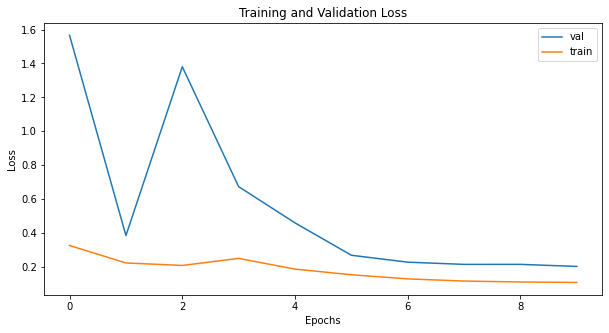

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_vgg = 'vgg_v2.pt'
path_vgg = F"/content/drive/MyDrive/Hacker/{model_vgg}" 
torch.save(vgg16.state_dict(), path_vgg)
model_eta = 'eta_v2.pt'
path_eta = F"/content/drive/MyDrive/Hacker/{model_eta}" 
torch.save(eta_decoder.state_dict(), path_eta)

In [ ]:
vgg16 = VGG16()
eta_decoder = EtaDecoder()
model_vgg = 'vgg_v1.pt'
path_vgg = F"/content/drive/MyDrive/Hacker/{model_vgg}" 
vgg16.load_state_dict(torch.load(path_vgg))
model_eta = 'eta_v1.pt'
path_eta = F"/content/drive/MyDrive/Hacker/{model_eta}" 
eta_decoder.load_state_dict(torch.load(path_eta))

<All keys matched successfully>

## ISTFT

In [ ]:
from scipy import signal

def istft(mag,phase):
  pred=librosa.istft(mag*phase,hop_length=128)
  return pred


## Generate enhanced audio

In [ ]:
def generate_enhanced_audio(vgg16,eta_decoder,seg_audio_folders):
  vgg16.eval()
  eta_decoder.eval()
  for it, seg_audio_folder in enumerate(seg_audio_folders):
    seg_audio_filepath = os.path.join(seg_audio_x,seg_audio_folder)
    seg_audio_files = os.listdir(seg_audio_filepath)
    x_batch = []
    x_phase_batch = []
    for seg_audio_file in seg_audio_files :
      spectro, spectro_mag, spectro_phase=(generate_spectrogram_magphase(os.path.join(seg_audio_filepath,seg_audio_file)))
      x_batch.append(transform(spectro_mag))
      x_phase_batch.append(spectro_phase)
    x_batch = torch.stack(x_batch)
    audio_emb, qa, ka, va = vgg16(x_batch)
    za_input = generate_attention(audio_emb,qa,ka,va)
    mask = eta_decoder(za_input)
    mask = torch.reshape(mask,(-1,1,257,251))
    clean_batch=mask*x_batch
  # i=0
  # audio=[]
  # for seg in clean_batch:
  #   i+=1
  #   audio.extend(istft(seg,x_phase_batch[i]))
  return clean_batch,x_phase_batch

## Testing
### Clean Audio

In [ ]:
import IPython
#true audio
speaker_id='M_HcFLa0b1Q'
IPython.display.Audio('/content/train/audio/'+speaker_id+'_audio.wav')

### Interrupted Audio

In [ ]:
#interrupted audio
IPython.display.Audio('/content/train/audio_2N/'+speaker_id+'_2N.wav')

### Enhnaced Audio

In [ ]:
seg_audio_x = "/content/train/segmented_audiofiles/"
enhanced_audio,x_phase_batch=generate_enhanced_audio(vgg16,eta_decoder,[speaker_id])
enhanced_audio = enhanced_audio.squeeze(1)
print(enhanced_audio.shape)
print(x_phase_batch[0].shape)
# IPython.display.Audio(enhanced_audio.detach().numpy())

torch.Size([6, 257, 251])
(257, 251, 1)


In [ ]:
audio=[]
for j in range(enhanced_audio.shape[0]):
  audio.extend(istft(enhanced_audio[j].detach().numpy(),np.squeeze(x_phase_batch[j],axis = 2)))

In [ ]:
from IPython.display import Audio
Audio(audio, rate = 16000)